In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# For GPU acceleration
device = torch.device('cuda')

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

def load_and_standardize(csv_file, seq_len, drop_first_column=True):
    """
    Load data from CSV file and return standardized X array.
    
    Args:
        csv_file (str): Path to the CSV file.
        seq_len (int): Length of the sequence.
        drop_first_column (bool): Whether to drop the first column of the CSV file, default is True.
    
    Returns:
        np.ndarray: Standardized data with shape [1, seq_len, channels].
    """
    # Read CSV file
    df = pd.read_csv(csv_file)
    
    # If needed, drop the first column (assuming it's not a feature column)
    if drop_first_column:
        df = df.iloc[:, 1:]
    
    # Get data shape
    n_samples, n_channels = df.shape
    
    # If seq_len is greater than the number of samples, raise an exception
    if seq_len > n_samples:
        raise ValueError("seq_len should not be greater than the number of samples in the CSV file.")
    
    # Convert to NumPy array
    data = df.values
    
    # Standardize each channel (column)
    scaler = StandardScaler()
    data_standardized = np.array([scaler.fit_transform(data[:, i].reshape(-1, 1)).flatten() for i in range(n_channels)]).T
    
    # Reshape data to [1, seq_len, channels]
    X = data_standardized[:seq_len, :].reshape(seq_len, n_channels)
    # X = data[:seq_len, :].reshape(seq_len, n_channels)
    
    return X


In [4]:
import numpy as np
import torch
from sklearn.feature_selection import mutual_info_regression

def compute_mutual_info_matrix_old(X_seq, mi_p=0.05, lag=1):
    """
    输入:
        X_seq: numpy array, shape (seq_len, channels)
        mi_p: float, proportion of mutual information to retain, e.g., 0.05
        lag: int, 滞后步数
    输出:
        causality_matrix: tensor, shape (channels, channels), 01 matrix
    """
    seq_len, channels = X_seq.shape
    mi_matrix = np.zeros((channels, channels))

    # 计算互信息矩阵
    for i in range(channels):
        for j in range(channels):
            if i == j:
                mi_matrix[i, j]=0.999
                continue  # Don't consider self-influence
            x_now = X_seq[lag:, i]
            y_past = X_seq[:-lag, j]
            mi = mutual_info_regression(
                y_past.reshape(-1, 1),
                x_now,
                discrete_features=False
            )[0]
            mi_matrix[i, j] = mi

    # Convert mutual information matrix to 01 matrix
    mi_flat = mi_matrix.flatten()
    threshold = np.percentile(mi_flat, 100 * (1 - mi_p))  # Take threshold for top mi_p proportion

    if mi_p == 0:
        causality_matrix=mi_matrix
    else:
        causality_matrix = (mi_matrix >= threshold).astype(np.float32)

    # Convert to tensor
    causality_matrix = torch.from_numpy(causality_matrix)

    return causality_matrix

In [5]:
import numpy as np
import torch
from sklearn.feature_selection import mutual_info_regression
from tqdm.notebook import tqdm  # Note: use notebook version of progress bar

def compute_mutual_info_matrix(X_seq, mi_p=0.05, lag=1):
    """
    输入:
        X_seq: numpy array, shape (seq_len, channels)
        mi_p: float, 保留互信息最大的比例，比如 0.05；若为 0 则保留原始互信息并归一化
        lag: int, 滞后步数
    输出:
        causality_matrix: tensor, shape (channels, channels)，每个值 ∈ [0, 1]，对角线为 0.9999
    """
    seq_len, channels = X_seq.shape
    mi_matrix = np.zeros((channels, channels), dtype=np.float32)

    # 计算互信息矩阵
    for i in tqdm(range(channels), desc="Computing MI"):
        for j in range(channels):
            if i == j:
                mi_matrix[i, j] = 0.0  # 初始设为 0，后面再改成 0.9999
                continue
            x_now = X_seq[lag:, i]
            y_past = X_seq[:-lag, j]
            mi = mutual_info_regression(
                y_past.reshape(-1, 1),
                x_now,
                discrete_features=False
            )[0]
            mi_matrix[i, j] = mi

    min_val = mi_matrix.min()
    max_val = mi_matrix.max()
    if max_val == min_val:
        mi_matrix = np.zeros_like(mi_matrix)
    else:
        mi_matrix = (mi_matrix - min_val) / (max_val - min_val)

    # 设置对角线为 0.9999
    np.fill_diagonal(mi_matrix, 0.9999)
    
    if mi_p == 0:
        causality_matrix = mi_matrix
    else:
        mi_flat = mi_matrix.flatten()
        threshold = np.percentile(mi_flat, 100 * (1 - mi_p))
        causality_matrix = (mi_matrix >= threshold).astype(np.float32)

    return torch.from_numpy(causality_matrix)


In [6]:

def compute_mutual_info_matrix_clip(X_seq, low_p=5, high_p=95, lag=1):
    """
    输入:
        X_seq: numpy array, shape (seq_len, channels)
        mi_p: float, 保留互信息最大的比例，比如 0.05；若为 0 则保留原始互信息并归一化
        lag: int, 滞后步数
    输出:
        causality_matrix: tensor, shape (channels, channels)，每个值 ∈ [0, 1]，对角线为 0.9999
    """
    seq_len, channels = X_seq.shape
    mi_matrix = np.zeros((channels, channels), dtype=np.float32)

    # 计算互信息矩阵
    for i in tqdm(range(channels), desc="Computing MI"):
        for j in range(channels):
            if i == j:
                mi_matrix[i, j] = 0.0  # 初始设为 0，后面再改成 0.9999
                continue
            x_now = X_seq[lag:, i]
            y_past = X_seq[:-lag, j]
            mi = mutual_info_regression(
                y_past.reshape(-1, 1),
                x_now,
                discrete_features=False
            )[0]
            mi_matrix[i, j] = mi

    # 计算 5% 和 95% 分位数
    low_q = np.percentile(mi_matrix, low_p)
    high_q = np.percentile(mi_matrix, high_p)

    # Clip to [5%, 95%] interval
    mi_matrix = np.clip(mi_matrix, low_q, high_q)

    # Normalize using clipped min and max values
    mi_matrix = (mi_matrix - low_q) / (high_q - low_q)

    # 设置对角线为 0.9999
    np.fill_diagonal(mi_matrix, 0.9999)

    return mi_matrix


In [7]:
import numpy as np
from tqdm import tqdm
import statsmodels.api as sm
import warnings

def compute_granger_causality_matrix(X_seq, maxlag=1):
    """
    Calculate causality matrix using Granger causality test.

    Parameters:
        X_seq: numpy array, shape (seq_len, channels)
        maxlag: int, maximum lag order

    Returns:
        causality_matrix: numpy array, shape (channels, channels), each value ∈ [0, 1], diagonal is 0.9999
    """
    seq_len, channels = X_seq.shape
    gc_matrix = np.zeros((channels, channels), dtype=np.float32)

    for i in tqdm(range(channels), desc="Computing Granger Causality"):
        for j in range(channels):
            if i == j:
                gc_matrix[i, j] = 0.0
                continue

            # Construct two-variable sequence
            x = X_seq[:, i]
            y = X_seq[:, j]
            data = np.column_stack([x, y])

            # Ignore statsmodels warnings, such as singular covariance matrix
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                try:
                    test_result = sm.tsa.stattools.grangercausalitytests(data, maxlag=maxlag, verbose=False)
                    # Use minimum p-value as measure of causal strength
                    p_values = [test[0]['ssr_ftest'][1] for lag, test in test_result.items()]
                    min_p_value = np.mean(p_values)
                    # 将 p 值转为“因果强度”，p 越大，因果性越强
                    gc_strength = min(1.0, min_p_value)
                except Exception:
                    gc_strength = 0.0

            gc_matrix[i, j] = gc_strength

    # 归一化
    # min_val = gc_matrix.min()
    # max_val = gc_matrix.max()

    # if max_val == min_val:
    #     gc_matrix = np.zeros_like(gc_matrix)
    # else:
    #     gc_matrix = (gc_matrix - min_val) / (max_val - min_val)

    # # 设置对角线为 0.9999
    # np.fill_diagonal(gc_matrix, 0.9999)

    return gc_matrix


In [8]:
import numpy as np
import torch
from tqdm import tqdm
from minepy import MINE

def compute_mine_matrix_threshold(X_seq, threshold=0.5, lag=1):
    """
    输入:
        X_seq: numpy array, shape (seq_len, channels)
        threshold: float, 阈值参数，当前保留为兼容旧接口
        lag: int, 滞后步数
    输出:
        causality_matrix: tensor, shape (channels, channels)，每个值 ∈ [0, 1]，对角线为 0.9999
    """
    seq_len, channels = X_seq.shape
    mi_matrix = np.zeros((channels, channels), dtype=np.float32)

    mine = MINE(alpha=0.6, c=15)  # You can adjust alpha and c parameters

    for i in tqdm(range(channels), desc="Computing MIC"):
        for j in range(channels):
            if i == j:
                mi_matrix[i, j] = 0.0
                continue

            x_now = X_seq[lag:, i]
            y_past = X_seq[:-lag, j]

            # Calculate MIC value
            mine.compute_score(y_past, x_now)
            mic = mine.mic()
            mi_matrix[i, j] = mic

    min_val = mi_matrix.min()
    max_val = mi_matrix.max()

    if max_val == min_val:
        mi_matrix = np.zeros_like(mi_matrix)
    else:
        mi_matrix = (mi_matrix - min_val) / (max_val - min_val)

    # 设置对角线为 0.9999
    np.fill_diagonal(mi_matrix, 0.9999)

    return mi_matrix


In [9]:
import numpy as np
import torch
from sklearn.feature_selection import mutual_info_regression
from tqdm.notebook import tqdm  

def compute_mutual_info_matrix_threshold(X_seq, threshold=0.5, lag=1):
    """
    输入:
        X_seq: numpy array, shape (seq_len, channels)
        mi_p: float, 保留互信息最大的比例，比如 0.05；若为 0 则保留原始互信息并归一化
        lag: int, 滞后步数
    输出:
        causality_matrix: tensor, shape (channels, channels)，每个值 ∈ [0, 1]，对角线为 0.9999
    """
    seq_len, channels = X_seq.shape
    mi_matrix = np.zeros((channels, channels), dtype=np.float32)

    # 计算互信息矩阵
    for i in tqdm(range(channels), desc="Computing MI"):
        for j in range(channels):
            if i == j:
                mi_matrix[i, j] = 0.0  # 初始设为 0，后面再改成 0.9999
                continue
            x_now = X_seq[lag:, i]
            y_past = X_seq[:-lag, j]
            mi = mutual_info_regression(
                y_past.reshape(-1, 1),
                x_now,
                discrete_features=False
            )[0]
            mi_matrix[i, j] = mi

    min_val = mi_matrix.min()
    max_val = mi_matrix.max()
    # 计算 5% 和 95% 分位数
    # low_q = np.percentile(mi_matrix, 5)
    # high_q = np.percentile(mi_matrix, 95)

    # # clip 到 [5%, 95%] 区间
    # mi_matrix = np.clip(mi_matrix, low_q, high_q)

    # # 使用 clipped 后的最小值和最大值进行归一化
    # mi_matrix = (mi_matrix - low_q) / (high_q - low_q)

    if max_val == min_val:
        mi_matrix = np.zeros_like(mi_matrix)
    else:
        mi_matrix = (mi_matrix - min_val) / (max_val - min_val)

    # 设置对角线为 0.9999
    np.fill_diagonal(mi_matrix, 0.9999)

    return torch.tensor(mi_matrix, dtype=torch.float32)
    # return mi_matrix


In [10]:
def average_mi_over_random_samples(data, sample_len=720, n_repeat=10, threshold=0, lag=1):
    """
    data: numpy array, shape (N, C)
    sample_len: int, length of each sample
    n_repeat: int, number of repetitions
    """
    N, C = data.shape
    mi_matrices = []

    for _ in tqdm(range(n_repeat), desc="Sampling & Computing MI"):
        start = np.random.randint(0, N - sample_len + 1)
        X_seq = data[start:start + sample_len]
        mi_matrix = compute_mutual_info_matrix_threshold(X_seq, threshold, lag)
        mi_matrices.append(mi_matrix)

    avg_mi_matrix = torch.stack(mi_matrices).mean(dim=0)
    return avg_mi_matrix.numpy()

In [11]:
def compute_only_threshold(mi_matrix, threshold=0.5, lag=1):
    
    if threshold == 0:
        causality_matrix = mi_matrix
    else:
        causality_matrix = (mi_matrix >= threshold).astype(np.float32)

    return torch.from_numpy(causality_matrix)


In [12]:
def compute_prob(mi_matrix, mi_p=0.5, lag=1):
    
    if mi_p == 0:
        causality_matrix = mi_matrix
    else:
        mi_flat = mi_matrix.flatten()
        threshold = np.percentile(mi_flat, 100 * (1 - mi_p))
        causality_matrix = (mi_matrix >= threshold).astype(np.float32)

    return torch.from_numpy(causality_matrix)


In [15]:
path = r"dataset/ECL/electricity.csv"
X_np = load_and_standardize(path, 720)
X = torch.tensor(X_np[np.newaxis], dtype=torch.float32, device=device)
X.shape

torch.Size([1, 720, 321])

In [ ]:
# Verify learned mi
GC_prob_etth1_720_lag5 = compute_mine_matrix_threshold(X_np, 0, 1)

Computing MIC:   0%|          | 0/321 [00:00<?, ?it/s]

In [ ]:
# Verify learned mi
GC_prob_etth1_720_lag5 = compute_mutual_info_matrix_threshold(X_np, 0, 1)

In [17]:
# Verify learned mean mi
GC_prob_etth1_720_lag5 = average_mi_over_random_samples(X_np, sample_len=720, n_repeat=1, threshold=0, lag=1)

Sampling & Computing MI:   0%|          | 0/1 [00:00<?, ?it/s]

Computing MI:   0%|          | 0/321 [00:00<?, ?it/s]

In [ ]:
GC = compute_only_threshold(GC_prob_etth1_720_lag5, 0, 1)
torch.save(GC, 'masks/stats/prob_avg10/ecl_720_lag1.pt')

Estimated variable usage = 55.15%


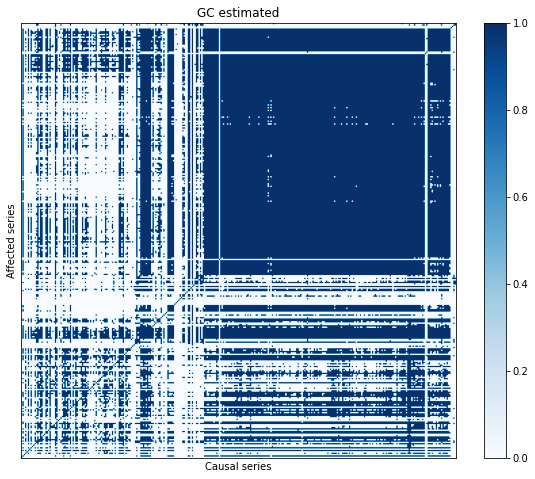

In [ ]:
GC = compute_only_threshold(GC_prob_etth1_720_lag5, 0.25, 1)
# GC = compute_prob(GC_prob, 0.40, 1)
GC_est = GC.cpu().data.numpy()

print('Estimated variable usage = %.2f%%' % (100 * np.mean(GC_est)))

# Make figures
fig, axarr = plt.subplots(1, 1, figsize=(10, 8))
im = axarr.imshow(GC_est, cmap='Blues', vmin=0, vmax=1, extent=(0, len(GC_est), len(GC_est), 0), origin='lower')
axarr.set_title('GC estimated')
axarr.set_ylabel('Affected series')
axarr.set_xlabel('Causal series')
axarr.set_xticks([])
axarr.set_yticks([])
cbar = plt.colorbar(im, ax=axarr)
# plt.savefig("img/ecl.png", dpi=300, bbox_inches='tight', transparent=True)
plt.show()

Estimated variable usage = 56.85%


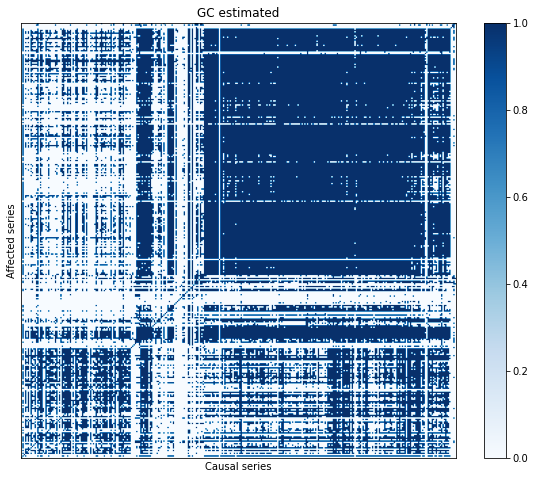

In [ ]:
GC = compute_only_threshold(GC_prob_etth1_720_lag5, 0.3, 1)
# GC = compute_prob(GC_prob, 0.40, 1)
GC_est = GC.cpu().data.numpy()

print('Estimated variable usage = %.2f%%' % (100 * np.mean(GC_est)))

# Make figures
fig, axarr = plt.subplots(1, 1, figsize=(10, 8))
im = axarr.imshow(GC_est, cmap='Blues', vmin=0, vmax=1, extent=(0, len(GC_est), len(GC_est), 0), origin='lower')
axarr.set_title('GC estimated')
axarr.set_ylabel('Affected series')
axarr.set_xlabel('Causal series')
axarr.set_xticks([])
axarr.set_yticks([])
cbar = plt.colorbar(im, ax=axarr)
# plt.savefig("img/ecl.png", dpi=300, bbox_inches='tight', transparent=True)
plt.show()

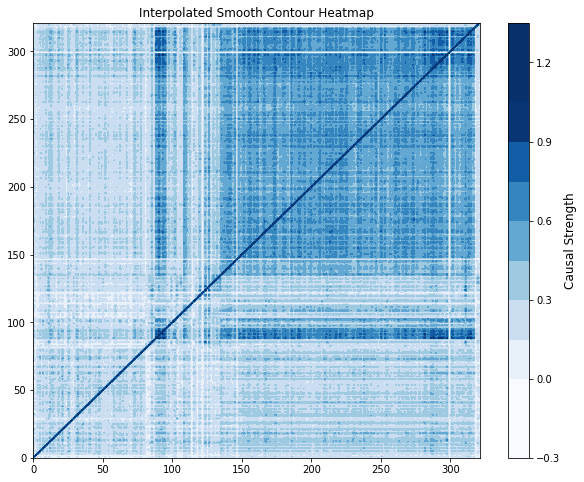

In [ ]:
from scipy.ndimage import zoom
from matplotlib.colors import ListedColormap, BoundaryNorm
import numpy as np
import matplotlib.pyplot as plt
colors = [
    (16/255,  70/255, 128/255),
    (49/255, 124/255, 183/255),
    (109/255, 173/255, 209/255),
    (182/255, 215/255, 232/255),
    (233/255, 241/255, 244/255),
    (251/255, 227/255, 213/255),
    (246/255, 178/255, 147/255),
    (220/255, 109/255, 87/255),
    (183/255, 34/255, 48/255),
    (109/255, 1/255, 31/255),
]

# Create colormap
custom_cmap = ListedColormap(colors)
# Zoom matrix, then draw contour plot
GC_zoomed = zoom(GC_est, zoom=5, order=3)  # Cubic spline interpolation

x = np.linspace(0, GC_est.shape[1], GC_zoomed.shape[1])
y = np.linspace(0, GC_est.shape[0], GC_zoomed.shape[0])
X, Y = np.meshgrid(x, y)

fig, ax = plt.subplots(figsize=(10, 8))
contour = ax.contourf(X, Y, GC_zoomed, levels=10, cmap="Blues", vmin=0, vmax=1)
# contour_lines = ax.contour(X, Y, GC_zoomed, levels=10, colors='black', linewidths=1)

cbar = plt.colorbar(contour, ax=ax)
cbar.set_label('Causal Strength', fontsize=12)
ax.set_title("Interpolated Smooth Contour Heatmap")
plt.savefig("img/ecl_heat.png", dpi=300, bbox_inches='tight', transparent=True)
plt.show()


Estimated variable usage-1 = 25.62%
Estimated variable usage-2 = 30.66%


[]

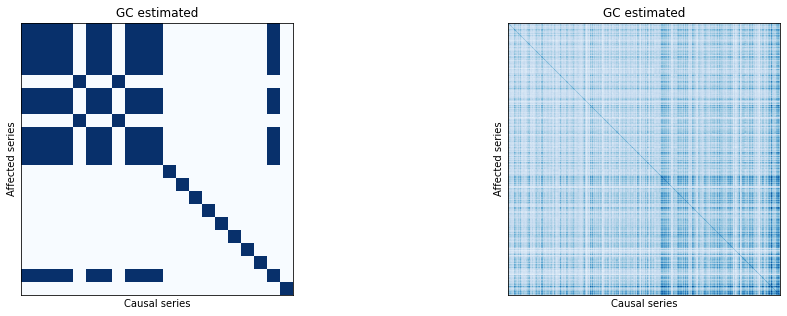

In [ ]:

# Verify learned Granger causality
GC_1 = torch.load("masks/stats_threshold/weather_720_50.pt")
GC_2 = torch.load("masks/stats/prob_clip97/traffic_720_lag5.pt")

GC_est_1 = GC_1.cpu().data.numpy()
GC_est_2 = GC_2.cpu().data.numpy()

print('Estimated variable usage-1 = %.2f%%' % (100 * np.mean(GC_est_1)))
print('Estimated variable usage-2 = %.2f%%' % (100 * np.mean(GC_est_2)))

# Make figures
fig, axarr = plt.subplots(1, 2, figsize=(16, 5))
axarr[0].imshow(GC_est_1, cmap='Blues', vmin=0, vmax=1, extent=(0, len(GC_est_1), len(GC_est_1), 0))
axarr[0].set_title('GC estimated')
axarr[0].set_ylabel('Affected series')
axarr[0].set_xlabel('Causal series')
axarr[0].set_xticks([])
axarr[0].set_yticks([])

axarr[1].imshow(GC_est_2, cmap='Blues', vmin=0, vmax=1, extent=(0, len(GC_est_2), len(GC_est_2), 0))
axarr[1].set_title('GC estimated')
axarr[1].set_ylabel('Affected series')
axarr[1].set_xlabel('Causal series')
axarr[1].set_xticks([])
axarr[1].set_yticks([])